In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [14]:
reload(dpp)
reload(pa)
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
# data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# data_dir_full = db.query('sess_name=="e15_13f1_220119"')['data_dir_full'][0]
data_dir_full = db.query('sess_name=="e15_13f1_220120"')['data_dir_full'][0]


# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [7]:
np.median(np.diff(spk_beh_df['time']))

0.03336666600080207

In [16]:
spk_beh_df

,1,2,3,4,5,6,7,8,9,10,...,trial_type,segment,dist_to_maze,off_track,on_track,off_track_event,pause_event,directed_locomotion,low_speed,lin_binned
146,1,1,1,1,0,0,1,0,2,1,...,"(0, 0.0)",3.0,1.108991,False,False,False,False,True,False,0
147,1,0,0,0,1,0,1,0,1,1,...,"(0, 0.0)",3.0,0.959754,False,True,False,False,True,False,0
148,1,1,0,2,0,0,0,0,2,3,...,"(0, 0.0)",3.0,0.678758,False,True,False,False,True,False,0
149,0,1,1,1,0,0,0,0,1,1,...,"(0, 0.0)",3.0,0.484495,False,True,False,False,True,False,0
150,3,3,0,1,1,0,1,1,0,2,...,"(0, 0.0)",3.0,0.324619,False,True,False,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115382,4,1,0,1,0,1,3,0,2,3,...,"(1, 1)",NaN,0.354684,False,True,False,False,False,True,3
115383,2,3,1,2,1,1,2,0,3,3,...,"(1, 1)",NaN,0.386277,False,True,False,False,False,True,3
115384,1,1,1,0,0,2,1,1,0,2,...,"(1, 1)",NaN,0.425922,False,True,False,False,False,True,3
115385,1,2,0,1,1,0,1,1,1,2,...,"(1, 1)",NaN,0.497258,False,True,False,False,False,True,2


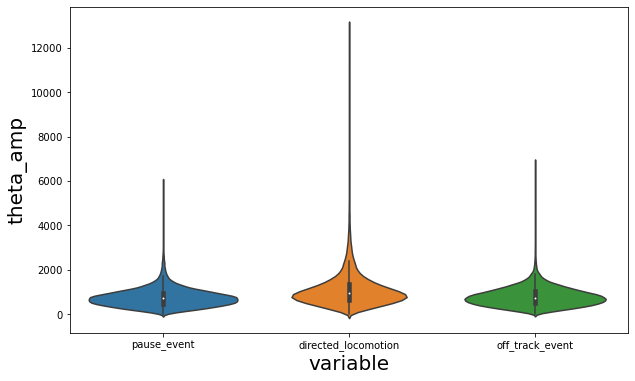

(0.0, 2000.0)

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Let's assume df is your original DataFrame
# df = ...

binary_columns = ['pause_event', 'directed_locomotion', 'off_track_event']
y_column = 'theta_amp'

# Create a copy of the DataFrame to avoid modifying the original one
df_copy = df.copy()

# Keep only the rows where at least one of the binary columns is True
df_copy = df_copy[df_copy[binary_columns].any(axis=1)]

# Reshape the DataFrame
melted_df = df_copy.melt(id_vars=y_column, value_vars=binary_columns)

# Keep only the rows where value is True
melted_df = melted_df[melted_df['value'] == True]


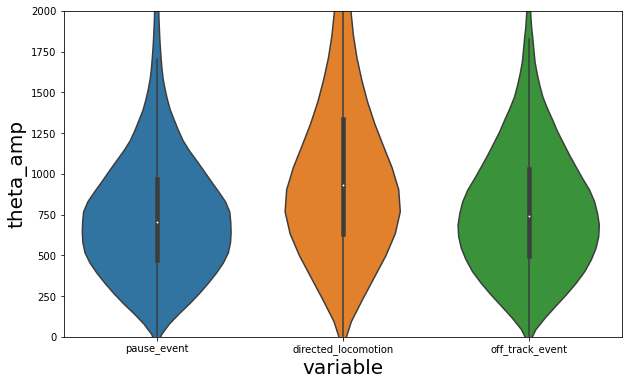

In [27]:
# Plot the reshaped DataFrame using seaborn
plt.figure(figsize=(10,6))
ax=sns.violinplot(x='variable', y=y_column, data=melted_df)
ax.set_ylim([0,2000])
plt.show()

In [30]:
fr_map = pa.get_fr_map_trial_multi_task(spk_beh_df,cell_cols_d['pyr'],trialtype_key_dict = {'alternation':'visitedArm','linearMaze':'direction'}, \
                                           order=['smooth','divide','average'],
                                              speed_key = 'directed_locomotion',
                                           speed_thresh = 0.5)


fr_map_trial = pa.get_fr_map_trial_multi_task(spk_beh_df,cell_cols_d['pyr'],trialtype_key_dict = {'alternation':'visitedArm','linearMaze':'direction'}, \
                                           order=['smooth','divide'],
                                              speed_key = 'directed_locomotion',
                                           speed_thresh = 0.5)



cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [42]:
pf.fr_map_trial_to_df(fr_map_trial[0][0],cell_cols_d['pyr'])

0         1         2         3         4    5         6   \
42.0  0   0.365731  0.131741  0.189310  0.188777  0.143998  0.0  0.278645   
      1   0.361740  0.150036  0.193293  0.209503  0.169000  0.0  0.270893   
      2   0.358638  0.182662  0.201922  0.233873  0.207558  0.0  0.259035   
      3   0.361797  0.222874  0.215133  0.249262  0.245400  0.0  0.247211   
      4   0.374342  0.262992  0.230417  0.252735  0.273042  0.0  0.237751   
...            ...       ...       ...       ...       ...  ...       ...   
303.0 95  0.030300  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
      96  0.024126  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
      97  0.017476  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
      98  0.012308  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   
      99  0.009571  0.000000  0.000000  0.000000  0.000000  0.0  0.000000   

                7         8         9   ...        17        18        19  \
42.0  0   0.167036  0.207550  0.265925  ...  0.074514  0.174140  0.066785   
      1   0.154657  0.228098  0.252802  ...  0.076220  0.171411  0.059504   
      2   0.135518  0.257751  0.226266  ...  0.080389  0.164356  0.050429   
      3   0.115322  0.283035  0.187262  ...  0.086875  0.152302  0.043141   
      4   0.097132  0.296798  0.141364  ...  0.094432  0.137232  0.038129   
...            ...       ...       ...  ...       ...       ...       ...   
303.0 95  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
      96  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
      97  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
      98  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
      99  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   

                20        21        22        23        24        25        26  
42.0  0   0.090951  0.155076  0.267028  0.032508  0.086072  0.006213  0.114462  
      1   0.080978  0.174870  0.272875  0.048315  0.111599  0.008596  0.133239  
      2   0.068372  0.192705  0.281118  0.070381  0.142863  0.011924  0.156877  
      3   0.057950  0.201237  0.289354  0.093679  0.167782  0.015248  0.176039  
      4   0.050280  0.202274  0.296267  0.117064  0.184425  0.018340  0.188501  
...            ...       ...       ...       ...       ...       ...       ...  
303.0 95  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      96  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      97  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      98  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
      99  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[24800 rows x 27 columns]

In [40]:
fr_map_trial[0][0]

array([[[0.36573079, 0.13174123, 0.18930983, ..., 0.08607187,
         0.00621339, 0.11446173],
        [0.36173952, 0.15003587, 0.19329341, ..., 0.11159867,
         0.00859594, 0.13323923],
        [0.35863806, 0.18266206, 0.20192204, ..., 0.14286327,
         0.01192421, 0.15687743],
        ...,
        [0.20910437, 0.2741899 , 0.49487139, ..., 0.525892  ,
         0.32026285, 0.34478835],
        [0.18675518, 0.23480247, 0.50493044, ..., 0.53874576,
         0.2782637 , 0.32327063],
        [0.17552613, 0.21639347, 0.51463825, ..., 0.54938578,
         0.25817154, 0.31134936]],

       [[0.13994252, 0.02951137, 0.04359244, ..., 0.01891825,
         0.08210675, 0.04467592],
        [0.13701011, 0.03599578, 0.05319403, ..., 0.0266571 ,
         0.08528726, 0.05415425],
        [0.13287111, 0.04804524, 0.06973736, ..., 0.03738387,
         0.09213517, 0.06509585],
        ...,
        [0.07655091, 0.04878797, 0.        , ..., 0.        ,
         0.        , 0.02328324],
        [0.0

In [8]:
import fr_map_one_session as fmos
reload(fmos)

<module 'fr_map_one_session' from '/mnt/home/szheng/projects/place_variability/code/fr_map_one_session.py'>

In [139]:
fmos.main(data_dir_full,force_reload=True)

cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/fr_map.p


In [127]:
reload(pa)
cell_cols = cell_cols_d['pyr']
speed_thresh=0.5
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide','average'])
fr_map_d={k:val[0] for k,val in fr_map_dict.items()}
fr_map_df_all = pd.concat(fr_map_d,axis=0)

fr_map_trial_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,gauss_width=2.5,trialtype_key='trial_type',speed_key='directed_locomotion',speed_thresh=speed_thresh,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_trial_dict.items()}
fr_map_trial_df_all=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)




cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [28]:
ddf=db.sort_values('n_neurons',ascending=False)['data_dir_full'][1]

In [66]:
%%time
for ddf in db.sort_values('n_neurons',ascending=False)['data_dir_full'].values:
    res=fmos.main(ddf,load_only=False,dosave=True,force_reload=True)

cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
cant format into a data

Error in session: /mnt/home/szheng/ceph/ad/ipshita_data/CA3_mEC/IZ33/IZ33_580um_210315_sess9
Traceback (most recent call last):
  File "/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'directed_locomotion'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/mnt/home/szheng/projects/place_variability/code/fr_map_one_session.py", line 76, in main
    res = analyze_data(data,*analysis_args,**analysis_kwargs)
  File "/mnt/

cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210302/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210317/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200809/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200809/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_10m1/e15_10m1_200812/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210312/py_data/fr_map.p
cant format into a dataframe
cant format into a dataframe
saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e

In [46]:
reload(pf)
fr_map_null = pf.get_fr_map_shuffle_wrapper(ddf,nrepeats=10, dosave=True,force_reload=True,bin_size=2.2,nbins = 100, save_fn='test.p',speed_thresh=0.5,speed_key='directed_locomotion')





100%|██████████| 10/10 [00:01<00:00,  6.61it/s]

saved at /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/test.p


In [47]:
fr_map_null

{(0,
  0.0): lin_binned        0         1         2         3         4         5   \
 0 31.0      0.072656  0.072382  0.071364  0.069263  0.066200  0.062605   
   32.0      0.029802  0.029718  0.030291  0.032036  0.034690  0.037399   
   33.0      0.044463  0.042051  0.037740  0.032389  0.026927  0.022127   
   34.0      0.050354  0.051740  0.054472  0.058438  0.063531  0.069780   
   35.0      0.058442  0.061914  0.067504  0.073707  0.079719  0.085422   
 ...              ...       ...       ...       ...       ...       ...   
 9 372.0     0.004357  0.004689  0.005059  0.005187  0.005008  0.004658   
   373.0     0.006242  0.005656  0.004715  0.003721  0.002913  0.002427   
   374.0     0.015219  0.014780  0.014064  0.013280  0.012575  0.011993   
   375.0     0.002574  0.002316  0.001890  0.001411  0.000973  0.000622   
   376.0     0.002746  0.002575  0.002293  0.001985  0.001717  0.001530   
 
 lin_binned        6         7         8         9   ...        90        91  \
 0 31.

In [50]:
reload(pf)
res=pf.field_detection_avg_wrapper(ddf, dosave=True,force_reload=False,nbins = 100, bin_size=2.2,
                                        save_fn = 'pf_test.p', 
                                        shuffle_fn='test.p',
                                        shuffle_force_reload=False,
                                        smth_in_bin=2.5, speed_thresh=0.5,speed_key='directed_locomotion',load_only=False,            
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/pf_test.p exists; loading---


In [51]:
res

{'params': {(0,
   0.0):                      0          1         2          3         4         5   \
  fr_mean 33  2  0.533887   1.049799  0.000000   0.882875  0.232768  2.220519   
          73  1  2.050463   1.585777  0.572211   0.000000  1.632053  3.312661   
          76  0  0.000000  13.483328  6.758564  10.575681  5.018421  6.953528   
          82  0  2.048231  10.396479  0.599730   1.526429  3.138802  0.738863   
              3  0.000000   0.190105  0.000000   0.332702  0.501838  1.645360   
  ...                 ...        ...       ...        ...       ...       ...   
  std     368 1  2.666497   4.270197       NaN   2.670638       NaN  3.256677   
          369 0  2.819358   2.709749  2.812109   3.499834  3.302751       NaN   
          374 0       NaN   3.830236  2.547792   3.744555  3.510127  3.041981   
          375 0       NaN        NaN       NaN        NaN  2.123852  1.742192   
          376 0  2.603078   3.691888  2.736613   3.291500  2.789165  2.655674   
  
  

In [20]:
cell_cols = cell_cols_d['pyr']
speed_key = 'directed_locomotion'
speed_thresh=0.5
bin_size=2.2
nbins=None
smth_in_bin=2.5

In [21]:
# fr_map_null = pf.get_fr_map_shuffle_wrapper(data_dir_full,nrepeats=1000, dosave=True,force_reload=shuffle_force_reload,bin_size=bin_size,nbins = nbins, save_fn=shuffle_fn,speed_key=speed_key,speed_thresh=speed_thresh)
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=speed_thresh,bin_size=bin_size,order=['smooth','divide'],speed_key=speed_key)
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_d,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=speed_thresh,nbins=nbins,bin_size=bin_size,smth_in_bin=smth_in_bin,speed_key=speed_key)

field_params_trial_avgmap_d, all_fields_d, sig_thresh_map_d = pf.field_detection_from_avg(fr_map_d,fr_map_trial_d,fr_map_null)



cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe


In [24]:
fn_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_afterheadscan.p'

import pickle 
res=pickle.load(open(fn_full,'rb'))

In [27]:
fr_map_null[0,1]

lin_binned        0         1         2         3         4         5   \
0   42.0    0.046612  0.049927  0.055960  0.063916  0.073033  0.082707   
    42.0    0.046612  0.049927  0.055960  0.063916  0.073033  0.082707   
    43.0    0.096068  0.092548  0.087715  0.083592  0.081132  0.080698   
    43.0    0.096068  0.092548  0.087715  0.083592  0.081132  0.080698   
    47.0    0.104125  0.101878  0.098567  0.095490  0.093572  0.093450   
...              ...       ...       ...       ...       ...       ...   
999 301.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    302.0   0.001939  0.001871  0.001868  0.002047  0.002449  0.003064   
    302.0   0.001939  0.001871  0.001868  0.002047  0.002449  0.003064   
    303.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    303.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

lin_binned        6         7         8         9   ...        90        91  \
0   42.0    0.092704  0.103386  0.115656  0.129970  ...  0.107499  0.099473   
    42.0    0.092704  0.103386  0.115656  0.129970  ...  0.107499  0.099473   
    43.0    0.082511  0.086772  0.093493  0.102037  ...  0.158624  0.152709   
    43.0    0.082511  0.086772  0.093493  0.102037  ...  0.158624  0.152709   
    47.0    0.095592  0.100323  0.107621  0.116574  ...  0.155362  0.150146   
...              ...       ...       ...       ...  ...       ...       ...   
999 301.0   0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
    302.0   0.003845  0.004724  0.005613  0.006420  ...  0.003361  0.003374   
    302.0   0.003845  0.004724  0.005613  0.006420  ...  0.003361  0.003374   
    303.0   0.000000  0.000000  0.000000  0.000000  ...  0.000716  0.001183   
    303.0   0.000000  0.000000  0.000000  0.000000  ...  0.000716  0.001183   

lin_binned        92        93        94        95        96        97  \
0   42.0    0.093072  0.090257  0.092615  0.100229  0.110556  0.119874   
    42.0    0.093072  0.090257  0.092615  0.100229  0.110556  0.119874   
    43.0    0.143333  0.132322  0.121097  0.111258  0.104367  0.100747   
    43.0    0.143333  0.132322  0.121097  0.111258  0.104367  0.100747   
    47.0    0.143356  0.135934  0.127800  0.118485  0.108603  0.099952   
...              ...       ...       ...       ...       ...       ...   
999 301.0   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    302.0   0.003497  0.003919  0.004823  0.006261  0.007983  0.009534   
    302.0   0.003497  0.003919  0.004823  0.006261  0.007983  0.009534   
    303.0   0.001659  0.001970  0.001945  0.001558  0.001001  0.000528   
    303.0   0.001659  0.001970  0.001945  0.001558  0.001001  0.000528   

lin_binned        98        99  
0   42.0    0.126076  0.128992  
    42.0    0.126076  0.128992  
    43.0    0.099367  0.099008  
    43.0    0.099367  0.099008  
    47.0    0.093961  0.091009  
...              ...       ...  
999 301.0   0.000000  0.000000  
    302.0   0.010606  0.011131  
    302.0   0.010606  0.011131  
    303.0   0.000245  0.000125  
    303.0   0.000245  0.000125  

[1209000 rows x 100 columns]

In [23]:
field_params_trial_avgmap_d[0,0]

0         1         2         3         4             5   \
fr_mean 79  0  3.344290  1.111711  0.000000  0.342600  0.916133  0.000000e+00   
        81  0  0.546199  0.251109  3.514062  2.243877  2.707909  4.844683e+00   
        84  0  0.692969  0.487543  0.766322  1.730714  0.706269  9.452294e-01   
        86  0  0.753781  0.588474  0.826160  0.520603  0.428542  6.783278e-01   
        88  0  1.016089  2.076063  1.429742  0.111085  0.254348  2.247304e+00   
...                 ...       ...       ...       ...       ...           ...   
std     282 3  4.429143  3.043420  2.528230  2.310081  2.395135  2.190864e+00   
        289 2  2.064916       NaN       NaN  1.690192       NaN  1.469192e+00   
        295 0  3.650902  2.994803  2.488413  2.644901  2.573319  3.552714e-15   
        299 3  2.667899  3.070145  2.656054  4.508079  4.467659  2.523496e+00   
        302 2  3.873579  3.799016  5.316973  4.759447  3.561766  4.699455e+00   

                     6          7         8         9   ...        17  \
fr_mean 79  0  1.954809   0.872412  0.827925  0.000000  ...  0.000000   
        81  0  5.389449  12.289624  3.734009  1.579573  ...  3.606556   
        84  0  0.871231   0.261724  0.353345  0.415783  ...  0.907248   
        86  0  0.645449   0.549913  1.064058  0.714118  ...  0.258681   
        88  0  0.210388   3.260859  0.594980  1.541812  ...  0.672741   
...                 ...        ...       ...       ...  ...       ...   
std     282 3  3.182775   3.298594  3.200144  3.933290  ...  2.560624   
        289 2       NaN        NaN       NaN  1.774602  ...  1.689731   
        295 0  3.005752   2.998886  2.798315  1.961353  ...  2.964924   
        299 3  2.951394   2.314382  2.347816  3.015974  ...  2.716264   
        302 2  4.037270   5.830715  5.001940  2.713378  ...  2.522310   

                     18        19        20        21        22        23  \
fr_mean 79  0  1.069789  0.191594  1.050545  0.000000  1.788160  1.302274   
        81  0  2.075519  5.628734  2.962352  0.973199  6.956597  3.987924   
        84  0  0.809001  0.767933  3.382649  0.000000  0.303386  0.487296   
        86  0  1.106198  0.434598  0.174258  0.632449  0.556198  0.430155   
        88  0  0.204267  1.072957  1.665849  0.916103  0.455167  1.215449   
...                 ...       ...       ...       ...       ...       ...   
std     282 3  3.095500  3.730790  3.079668  4.070704  2.443731  4.349181   
        289 2  1.861482  1.633882  1.878801       NaN  1.721613  1.954423   
        295 0  2.860102  3.045298  2.709711  3.104708  2.831837  3.350702   
        299 3  3.762997  2.580230  3.174085  2.860015  2.506516  2.408007   
        302 2  4.933507  7.516412  4.226095  2.320098  5.930991  5.776306   

                     24        25        26  
fr_mean 79  0  0.220661  0.225954  1.392346  
        81  0  4.363201  9.954019  6.229809  
        84  0  0.348011  1.409811  0.398784  
        86  0  0.157927  0.905443  0.772750  
        88  0  0.707944  1.066033  1.585092  
...                 ...       ...       ...  
std     282 3  3.427812  2.950281  3.857898  
        289 2       NaN  1.519885  2.155458  
        295 0  3.150522  3.008394  3.115206  
        299 3  2.420794  2.285842  2.619141  
        302 2  7.459362       NaN  3.142455  

[365 rows x 27 columns]

In [10]:
res[0,0].loc[0]

lin_binned,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
42.0,0.124067,1.202797e-01,1.144357e-01,0.108543,0.104090,0.102124,0.103468,0.108787,0.118249,0.130592,...,0.182049,0.195583,0.200707,0.195154,1.806887e-01,0.163130,0.148530,0.139435,0.135045,0.133483
42.0,0.124067,1.202797e-01,1.144357e-01,0.108543,0.104090,0.102124,0.103468,0.108787,0.118249,0.130592,...,0.182049,0.195583,0.200707,0.195154,1.806887e-01,0.163130,0.148530,0.139435,0.135045,0.133483
43.0,0.087282,8.513397e-02,8.191690e-02,0.078764,0.076292,0.074650,0.073686,0.073010,0.071963,0.069672,...,0.065783,0.068748,0.070011,0.068568,6.458922e-02,0.059528,0.055118,0.052242,0.050791,0.050255
43.0,0.087282,8.513397e-02,8.191690e-02,0.078764,0.076292,0.074650,0.073686,0.073010,0.071963,0.069672,...,0.065783,0.068748,0.070011,0.068568,6.458922e-02,0.059528,0.055118,0.052242,0.050791,0.050255
47.0,0.122517,1.173734e-01,1.095680e-01,0.101633,0.094836,0.089362,0.084776,0.080370,0.075535,0.070404,...,0.108309,0.109260,0.111520,0.113201,1.121589e-01,0.107704,0.101075,0.094312,0.089046,0.086214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301.0,0.000000,1.947326e-07,8.053221e-07,0.000003,0.000009,0.000027,0.000073,0.000182,0.000410,0.000807,...,0.000542,0.000680,0.000933,0.001143,1.170692e-03,0.000990,0.000700,0.000426,0.000237,0.000146
302.0,0.014309,1.270135e-02,1.029453e-02,0.007877,0.005817,0.004194,0.002986,0.002205,0.002015,0.002837,...,0.003217,0.001952,0.001358,0.001259,1.389882e-03,0.001540,0.001635,0.001696,0.001747,0.001781
302.0,0.014309,1.270135e-02,1.029453e-02,0.007877,0.005817,0.004194,0.002986,0.002205,0.002015,0.002837,...,0.003217,0.001952,0.001358,0.001259,1.389882e-03,0.001540,0.001635,0.001696,0.001747,0.001781
303.0,0.000047,8.202977e-05,1.467879e-04,0.000234,0.000337,0.000443,0.000539,0.000604,0.000612,0.000541,...,0.000143,0.000051,0.000015,0.000004,7.846574e-07,0.000000,0.000000,0.000000,0.000000,0.000000


In [77]:
res

{(0,
  0.0): lin_binned        0         1         2         3         4         5   \
 0 42.0      0.112810  0.116158  0.121355  0.127073  0.132900  0.138988   
   42.0      0.112810  0.116158  0.121355  0.127073  0.132900  0.138988   
   43.0      0.084126  0.084006  0.084083  0.084550  0.085288  0.085970   
   43.0      0.084126  0.084006  0.084083  0.084550  0.085288  0.085970   
   47.0      0.105996  0.106060  0.105536  0.103962  0.101384  0.098102   
 ...              ...       ...       ...       ...       ...       ...   
 9 301.0     0.001195  0.000959  0.000643  0.000387  0.000244  0.000222   
   302.0     0.011869  0.011370  0.010930  0.010947  0.011382  0.011943   
   302.0     0.011869  0.011370  0.010930  0.010947  0.011382  0.011943   
   303.0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
   303.0     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 
 lin_binned        6         7         8         9   ...        90        91  \
 0 42.

In [74]:
reload(pf)
cell_cols = cell_cols_d['pyr']
res = pf.get_fr_map_shuffle(spk_beh_df,cell_cols,nrepeats=3,dosave=False,save_fn='',speed_key='directed_locomotion',speed_thresh=1.)



AssertionError: Gaps in blk ref_locs

In [72]:
res

{(0,
  0.0): lin_binned        0         1         2         3         4         5   \
 0 42.0      0.097679  0.094077  0.089356  0.085754  0.083972  0.083624   
   43.0      0.062091  0.065199  0.069599  0.073486  0.076015  0.077095   
   47.0      0.120074  0.118047  0.115517  0.113996  0.114168  0.116031   
   48.0      0.142348  0.143886  0.146442  0.149428  0.152406  0.155045   
   51.0      0.075314  0.072413  0.068360  0.064832  0.062537  0.061483   
 ...              ...       ...       ...       ...       ...       ...   
 2 299.0     0.002885  0.003325  0.004017  0.004764  0.005460  0.006079   
   300.0     0.000119  0.000173  0.000259  0.000350  0.000428  0.000480   
   301.0     0.002304  0.002540  0.002824  0.002986  0.002972  0.002803   
   302.0     0.005680  0.005946  0.006285  0.006506  0.006519  0.006304   
   303.0     0.000754  0.000698  0.000598  0.000477  0.000364  0.000291   
 
 lin_binned        6         7         8         9   ...        90        91  \
 0 42.

In [69]:
reload(pf)
res=pf.field_detection_avg_wrapper(data_dir_full, dosave=True,force_reload=True,nbins = 100, bin_size=2.2,
                                        save_fn = 'place_field_afterheadscan.p', 
                                        shuffle_fn='frmap_null_afterheadscan.p',
                                        smth_in_bin=2.5, speed_thresh=0.5,speed_key='directed_locomotion',load_only=False
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/frmap_null_afterheadscan.p exists; loading---
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
cant format into a dataframe
> /mnt/home/szheng/projects/util_code/place_field_analysis.py(658)field_detection_from_avg()
    656         try:
    657             pdb.set_trace()
--> 658             cell_cols = fr_map_d[key].index
    659             fr_map_trial = fr_map_trial_d[key]
    660             fr_map_trial_df=fr_map_trial_to_df(fr_map_trial,cell_cols)

ipdb> n
> /mnt/home/szheng/projects/util_code/place_field_analysis.py(659)field_detection_from_avg()
    657             pdb.set_trace()
    658             cell_cols = fr_map_d[key].index
--> 659             fr_map_trial = fr_map_trial_d[key]
    660             fr_map_trial_df=fr_map_trial_to_df(fr_map_trial,cell_cols)
    661             all_fields_bounds_avg, sig_thresh_map=detect_significant_segments(fr_map_null[key],fr

ipdb> exit
(0, 0.0) doesn't work: 
> /mnt/home/szheng/projects/util_code/place_field_analysis.py(657)field_detection_from_avg()
    655     for key in fr_map_d.keys():
    656         try:
--> 657             pdb.set_trace()
    658             cell_cols = fr_map_d[key].index
    659             fr_map_trial = fr_map_trial_d[key]

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
(0, 1.0) doesn't work: Cannot infer number of levels from empty list
> /mnt/home/szheng/projects/util_code/place_field_analysis.py(658)field_detection_from_avg()
    656         try:
    657             pdb.set_trace()
--> 658             cell_cols = fr_map_d[key].index
    659             fr_map_trial = fr_map_trial_d[key]
    660             fr_map_trial_df=fr_map_trial_to_df(fr_map_trial,cell_cols)

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
(1, 0) doesn't work: Cannot infer number of levels from empty list
> /mnt/home/szheng/projects/util_code/place_field_analysis.py(657)fiel

In [40]:
res.keys()

dict_keys(['fr_map', 'fr_map_trial', 'fr_map_trial_df'])

<AxesSubplot:xlabel='lin_binned'>

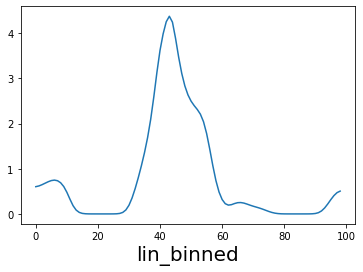

In [64]:
res['fr_map'].loc[0,0].loc[210].plot()

<AxesSubplot:xlabel='lin_binned'>

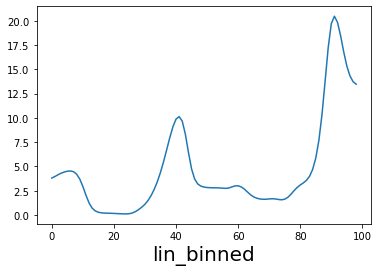

In [125]:
fr_map_df_all.loc[0,0].loc[42].plot()

<AxesSubplot:>

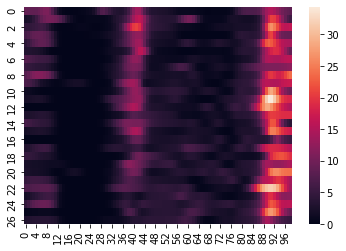

In [126]:
sns.heatmap(data=fr_map_trial_df_all.loc[0,0].loc[42].T)

In [49]:
fr_map_trial_df_d

0         1         2         3         4    5   \
0 0.0 42.0  0   0.365731  0.131741  0.189310  0.188777  0.143998  0.0   
            1   0.361740  0.150036  0.193293  0.209503  0.169000  0.0   
            2   0.358638  0.182662  0.201922  0.233873  0.207558  0.0   
            3   0.361797  0.222874  0.215133  0.249262  0.245400  0.0   
            4   0.374342  0.262992  0.230417  0.252735  0.273042  0.0   
...                  ...       ...       ...       ...       ...  ...   
1 1.0 303.0 33  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
            34  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
            35  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
            36  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
            37  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   

                      6         7         8         9   ...        17  \
0 0.0 42.0  0   0.278645  0.167036  0.207550  0.265925  ...  0.074514   
            1   0.270893  0.154657  0.228098  0.252802  ...  0.076220   
            2   0.259035  0.135518  0.257751  0.226266  ...  0.080389   
            3   0.247211  0.115322  0.283035  0.187262  ...  0.086875   
            4   0.237751  0.097132  0.296798  0.141364  ...  0.094432   
...                  ...       ...       ...       ...  ...       ...   
1 1.0 303.0 33  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
            34  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
            35  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
            36  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
            37  0.000000  0.000000  0.000000  0.000000  ...  0.000000   

                      18        19        20        21        22        23  \
0 0.0 42.0  0   0.174140  0.066785  0.090951  0.155076  0.267028  0.032508   
            1   0.171411  0.059504  0.080978  0.174870  0.272875  0.048315   
            2   0.164356  0.050429  0.068372  0.192705  0.281118  0.070381   
            3   0.152302  0.043141  0.057950  0.201237  0.289354  0.093679   
            4   0.137232  0.038129  0.050280  0.202274  0.296267  0.117064   
...                  ...       ...       ...       ...       ...       ...   
1 1.0 303.0 33  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
            34  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
            35  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
            36  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
            37  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                      24        25        26  
0 0.0 42.0  0   0.086072  0.006213  0.114462  
            1   0.111599  0.008596  0.133239  
            2   0.142863  0.011924  0.156877  
            3   0.167782  0.015248  0.176039  
            4   0.184425  0.018340  0.188501  
...                  ...       ...       ...  
1 1.0 303.0 33       NaN       NaN       NaN  
            34       NaN       NaN       NaN  
            35       NaN       NaN       NaN  
            36       NaN       NaN       NaN  
            37       NaN       NaN       NaN  

[68448 rows x 27 columns]

In [48]:
fr_map_trial_d[0,0].shape

(248, 100, 27)